In [48]:
import torch
import torch.nn as nn
from typing import Tuple, Union, Optional, List
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [49]:
# a utility for calculating running average
class AverageMeter:
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val * sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num / self.tot

# Problem 2: Implement a Transformer

## Part 2.A

In [50]:
class AttentionHead(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim: the dimension of the input
        # n_hidden: the dimension of the keys, queries, and values

        super().__init__()

        self.W_K = nn.Linear(dim, n_hidden)  # W_K weight matrix
        self.W_Q = nn.Linear(dim, n_hidden)  # W_Q weight matrix
        self.W_V = nn.Linear(dim, n_hidden)  # W_V weight matrix
        self.n_hidden = n_hidden

    def forward(
        self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing self-attention on x. shape: (Batch x Num_tokens x n_hidden)
        # alpha            the attention weights (after softmax). shape: (B x T x T)
        #

        out, alpha = None, None
        # TODO: Compute self attention on x.
        #       (1) First project x to the query Q, key K, value V.
        #       (2) Then compute the attention weights alpha as:
        #                  alpha = softmax(QK^T/sqrt(n_hidden))
        #           Make sure to take into account attn_mask such that token i does not attend on token
        #           j if attn_mask[b, i, j] == 0. (Hint, in such a case, what value should you set the weight
        #           to before the softmax so that after the softmax the value is 0?)
        #       (3) The output is a linear combination of the values (weighted by the alphas):
        #                  out = alpha V
        #       (4) return the output and the alpha after the softmax

        # ======= Answer START ========

        query = self.W_Q(x)
        key = self.W_K(x)
        value = self.W_V(x)
        scores = torch.matmul(query, key.transpose(-2, -1)) / self.n_hidden**0.5
        if attn_mask is not None:
            attn_mask = attn_mask.to(scores.device)
            scores = scores.masked_fill(attn_mask == 0, float("-inf"))
        alpha = torch.softmax(scores, dim=-1)
        attn_output = torch.matmul(alpha, value)

        # ======= Answer  END ========

        return attn_output, alpha

## Part 2.B

In [51]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, dim: int, n_hidden: int, num_heads: int):
        # dim: the dimension of the input
        # n_hidden: the hidden dimenstion for the attention layer
        # num_heads: the number of attention heads
        super().__init__()

        # TODO: set up your parameters for multi-head attention. You should initialize
        #       num_heads attention heads (see nn.ModuleList) as well as a linear layer
        #       that projects the concatenated outputs of each head into dim
        #       (what size should this linear layer be?)

        # ======= Answer START ========
        self.num_heads = num_heads
        self.n_hidden = n_hidden
        self.attn_heads = nn.ModuleList(
            [AttentionHead(dim=dim, n_hidden=n_hidden) for _ in range(num_heads)]
        )
        self.project_layer = nn.Linear(num_heads * n_hidden, dim)

        # ======= Answer  END ========

    def forward(
        self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing multi-headed self-attention on x.
        #                  shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_output, attn_alphas = None, None

        # TODO: Compute multi-headed attention. Loop through each of your attention heads
        #       and collect the outputs. Concatenate them together along the hidden dimension,
        #       and then project them back into the output dimension (dim). Return both
        #       the final attention outputs as well as the alphas from each head.

        # ======= Answer START ========

        outputs = []
        alphas = []
        for attn_layer in self.attn_heads:
            output, alpha = attn_layer(x=x, attn_mask=attn_mask)
            outputs.append(output)  # output (B, T, n_hidden)
            alphas.append(alpha)  # alpha (B, T, T)

        attn_output = torch.cat(outputs, dim=-1)  # (B,T,Num_heads*n_hidden)
        attn_alphas = torch.stack(alphas, dim=1)  # (B,Num_heads,T,T)
        attn_output = self.project_layer(attn_output)  # (B,Num_heads,dim)

        # ======= Answer END ========
        return attn_output, attn_alphas

## Part 2.C

In [52]:
# these are already implemented for you!


class FFN(nn.Module):
    def __init__(self, dim: int, n_hidden: int):

        # dim       the dimension of the input

        # n_hidden  the width of the linear layer

        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # x         the input. shape: (B x T x dim)

        # Outputs:

        # out       the output of the feed-forward network: (B x T x dim)
        return self.net(x)


class AttentionResidual(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int):

        # dim       the dimension of the input

        # attn_dim  the hidden dimension of the attention layer

        # mlp_dim   the hidden layer of the FFN

        # num_heads the number of heads in the attention layer
        super().__init__()

        self.attn = MultiHeadedAttention(dim, attn_dim, num_heads)

        self.ffn = FFN(dim, mlp_dim)

    def forward(
        self, x: torch.Tensor, attn_mask: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        # x                the inputs. shape: (B x T x dim)

        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]

        #                  contains 1 if (in batch b) token i should attend on token j and 0

        #                  otherwise. shape: (B x T x T)

        #

        # Outputs:

        # attn_output      shape: (B x T x dim)

        # attn_alphas      the attention weights of each of the attention heads.

        #                  shape: (B x Num_heads x T x T)

        attn_out, alphas = self.attn(x=x, attn_mask=attn_mask)

        x = attn_out + x

        x = self.ffn(x) + x
        return x, alphas

In [53]:
class Transformer(nn.Module):
    def __init__(
        self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int
    ):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        # num_layers the number of attention layers.
        super().__init__()

        # TODO: set up the parameters for the transformer!
        #       You should set up num_layers of AttentionResiduals
        #       nn.ModuleList will be helpful here.

        # ======= Answer START ========
        self.attn_net = nn.ModuleList(
            [
                AttentionResidual(
                    dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads
                )
                for _ in range(num_layers)
            ]
        )

        # ======= Answer END ========

    def forward(
        self, x: torch.Tensor, attn_mask: torch.Tensor, return_attn=False
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. Pass this to each of the AttentionResidual layers!
        #                  shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      If return_attn is False, return None. Otherwise return the attention weights
        #                  of each of each of the attention heads for each of the layers.
        #                  shape: (B x Num_layers x Num_heads x T x T)

        output, collected_attns = None, None

        # TODO: Implement the transformer forward pass! Pass the input successively through each of the
        # AttentionResidual layers. If return_attn is True, collect the alphas along the way.

        # ======= Answer START ========
        attn_alphas = []
        for attn_res in self.attn_net:
            x, alphas = attn_res(x=x, attn_mask=attn_mask)
            attn_alphas.append(alphas)
        output = x
        if return_attn:
            collected_attns = torch.stack(attn_alphas, dim=1)

        # ======= Answer END ========

        return output, collected_attns

Test your transformer implementation here

In [54]:
def perform_transformer_test_cases():
    num_tokens = 100
    batch_size = 10
    dim = 64
    num_layers = 4
    num_heads = 2
    dummy_model = Transformer(
        dim=dim, attn_dim=32, mlp_dim=dim, num_heads=num_heads, num_layers=num_layers
    ).cuda()

    inp = torch.randn(batch_size, num_tokens, dim).cuda()

    # test case 1 regular forward pass
    print("Test Case 1")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None)
        assert alpha is None
        assert output.shape == (
            batch_size,
            num_tokens,
            dim,
        ), f"wrong output shape {output.shape}"

    # test case 2 collect attentions
    print("Test Case 2")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None, return_attn=True)
        assert output.shape == (
            batch_size,
            num_tokens,
            dim,
        ), f"wrong output shape {output.shape}"
        assert alpha.shape == (
            batch_size,
            num_layers,
            num_heads,
            num_tokens,
            num_tokens,
        ), f"wrong alpha shape {alpha.shape}"

    print("Test Case 3")
    # test case 3 with attention mask
    attn_mask = torch.zeros(batch_size, num_tokens, num_tokens).cuda()
    attn_mask[:, torch.arange(num_tokens), torch.arange(num_tokens)] = 1
    attn_mask[:, torch.arange(num_tokens)[1:], torch.arange(num_tokens)[:-1]] = 1
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=attn_mask, return_attn=True)
        print("Attention mask pattern", attn_mask[0])
        print("Alpha pattern", alpha[0, 0, 0])
        assert torch.all(alpha.permute(1, 2, 0, 3, 4)[:, :, attn_mask == 0] == 0).item()

    print("Test Case 4")
    # test case 4 creates a causal mask where each token can only attend to previous tokens and itself
    causal_mask = (
        torch.tril(torch.ones(num_tokens, num_tokens))
        .unsqueeze(0)
        .repeat(batch_size, 1, 1)
    )  # Shape: (B, T, T)

    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=causal_mask, return_attn=True)
        # Verify the causal mask
        for b in range(batch_size):
            for l in range(num_layers):
                for h in range(num_heads):
                    attn_weights = alpha[b, l, h]  # Shape: (T, T)
                    # Positions where j > i should have zero attention weights
                    # We can create a boolean mask for j > i
                    future_mask = torch.triu(
                        torch.ones(num_tokens, num_tokens), diagonal=1
                    ).bool()  # Shape: (T, T)
                    # Extract attention weights for future positions
                    future_attn = attn_weights[future_mask]
                    # Assert that these weights are close to zero
                    assert torch.all(
                        future_attn < 1e-6
                    ), f"Causal mask violated in batch {b}, layer {l}, head {h}"


perform_transformer_test_cases()

Test Case 1
Test Case 2
Test Case 3
Attention mask pattern tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]], device='cuda:0')
Alpha pattern tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4800, 0.5200, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5665, 0.4335,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4485, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5621, 0.4379, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6451, 0.3549]],
       device='cuda:0')
Test Case 4


## Problem 3: Vision Transformer

## Part 3.A

In [55]:
class PatchEmbed(nn.Module):
    """Image to Patch Embedding"""

    def __init__(self, img_size: int, patch_size: int, nin: int, nout: int):
        # img_size       the width and height of the image. you can assume that
        #                the images will be square
        # patch_size     the width of each square patch. You can assume that
        #                img_size is divisible by patch_size
        # nin            the number of input channels
        # nout           the number of output channels

        super().__init__()
        assert img_size % patch_size == 0

        self.img_size = img_size
        self.num_patches = (img_size // patch_size) ** 2
        # TODO Set up parameters for the Patch Embedding
        # ======= Answer START ========
        self.patch_size = patch_size
        self.conv2d = nn.Conv2d(
            in_channels=nin,
            out_channels=nout,
            kernel_size=patch_size,
            stride=patch_size,
        )

        # ======= Answer END ========

    def forward(self, x: torch.Tensor):
        # x        the input image. shape: (B, nin, Height, Width)
        #
        # Output
        # out      the patch embeddings for the input. shape: (B, num_patches, nout)

        # TODO: Implement the patch embedding. You want to split up the image into
        # square patches of the given patch size. Then each patch_size x patch_size
        # square should be linearly projected into an embedding of size nout.
        #
        # Hint: Take a look at nn.Conv2d. How can this be used to perform the
        #       patch embedding?
        out = None

        # ======= Answer START ========
        x = self.conv2d(x)  # (B,nout,sqrt(num_patch),sqrt(num_patch))
        x = x.flatten(start_dim=2, end_dim=-1)  # (B,nout,num_patches,)
        out = x.transpose(1, 2)  # (B, num_patches, nout)

        # ======= Answer END ========

        return out

## Part 3.B

In [56]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        n_channels: int,
        nout: int,
        img_size: int,
        patch_size: int,
        dim: int,
        attn_dim: int,
        mlp_dim: int,
        num_heads: int,
        num_layers: int,
    ):
        # n_channels       number of input image channels
        # nout             desired output dimension
        # img_size         width of the square image
        # patch_size       width of the square patch
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.
        super().__init__()
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, nin=n_channels, nout=dim
        )  # out (B, num_patches, nout)
        self.pos_E = nn.Embedding(
            (img_size // patch_size) ** 2, dim
        )  # positional embedding matrix

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))  # learned class embedding
        self.transformer = Transformer(
            dim=dim,
            attn_dim=attn_dim,
            mlp_dim=mlp_dim,
            num_heads=num_heads,
            num_layers=num_layers,
        )

        self.head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, nout))

    def forward(
        self, img: torch.Tensor, return_attn=False
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # img          the input image. shape: (B, nin, img_size, img_size)
        # return_attn  whether to return the attention alphas
        #
        # Outputs
        # out          the output of the vision transformer. shape: (B, nout)
        # alphas       the attention weights for all heads and layers. None if return_attn is False, otherwise
        #              shape: (B, num_layers, num_heads, num_patches + 1, num_patches + 1)

        # generate embeddings
        embs = self.patch_embed(img)  # patch embedding (B, num_patches, nout)
        B, T, _ = embs.shape
        pos_ids = torch.arange(T).expand(B, -1).to(embs.device)
        embs += self.pos_E(pos_ids)  # positional embedding

        cls_token = self.cls_token.expand(len(embs), -1, -1)  # (B,1,dim)
        x = torch.cat([cls_token, embs], dim=1)

        x, alphas = self.transformer(x, attn_mask=None, return_attn=return_attn)
        out = self.head(x)[:, 0]  # select cls_token
        return out, alphas

## Part 3.C

In [57]:
# set up the dataset and dataloader

MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]
img_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ]
)
inv_transform = transforms.Compose(
    [
        transforms.Normalize(mean=[0.0, 0.0, 0.0], std=1 / np.array(STD)),
        transforms.Normalize(mean=-np.array(MEAN), std=[1.0, 1.0, 1.0]),
        transforms.ToPILImage(),
    ]
)


train_dataset = torchvision.datasets.CIFAR10(
    train=True, root="data", transform=img_transform, download=True
)
val_dataset = torchvision.datasets.CIFAR10(
    train=False, root="data", transform=img_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=10
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=256, shuffle=False, num_workers=10
)

Files already downloaded and verified


In [58]:
# set up the model and optimizer

import torch.optim as optim

model = VisionTransformer(
    n_channels=3,
    nout=10,
    img_size=32,
    patch_size=4,
    dim=128,
    attn_dim=64,
    mlp_dim=128,
    num_heads=3,
    num_layers=6,
).cuda()

criterion = nn.CrossEntropyLoss()


NUM_EPOCHS = 10
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [59]:
# evaluate the model
def evaluate_cifar_model(model, criterion, val_loader):
    is_train = model.training
    model.eval()
    with torch.no_grad():
        loss_meter, acc_meter = AverageMeter(), AverageMeter()
        for img, labels in val_loader:
            # move all img, labels to device (cuda)
            img = img.cuda()
            labels = labels.cuda()
            outputs, _ = model(img)
            loss_meter.update(criterion(outputs, labels).item(), len(img))
            acc = (outputs.argmax(-1) == labels).float().mean().item()
            acc_meter.update(acc, len(img))
    model.train(is_train)
    return loss_meter.calculate(), acc_meter.calculate()

In [60]:
# Time Estimate: less than 5 minutes on T4 GPU
# train the model
import tqdm

for epoch in range(NUM_EPOCHS):  #
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    for img, labels in tqdm.tqdm(train_dataloader):
        img, labels = img.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs, _ = model(img)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), len(img))
        acc = (outputs.argmax(-1) == labels).float().mean().item()
        acc_meter.update(acc, len(img))
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(
        f"Train Epoch: {epoch}, Loss: {loss_meter.calculate()}, Acc: {acc_meter.calculate()}"
    )
    if epoch % 10 == 0:
        val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
        print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")

val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
print("Finished Training")

100%|██████████| 196/196 [00:35<00:00,  5.55it/s]


Train Epoch: 0, Loss: 1.6804874281692506, Acc: 0.38952
Val Epoch: 0, Loss: 1.5092397380828857, Acc: 0.4563


100%|██████████| 196/196 [00:29<00:00,  6.57it/s]


Train Epoch: 1, Loss: 1.3700932378387451, Acc: 0.5073200000381469


100%|██████████| 196/196 [00:44<00:00,  4.45it/s]


Train Epoch: 2, Loss: 1.2277209970474243, Acc: 0.55962


100%|██████████| 196/196 [00:29<00:00,  6.68it/s]


Train Epoch: 3, Loss: 1.116184849205017, Acc: 0.59924


100%|██████████| 196/196 [00:28<00:00,  6.76it/s]


Train Epoch: 4, Loss: 1.0049517052459718, Acc: 0.640800000038147


100%|██████████| 196/196 [00:29<00:00,  6.72it/s]


Train Epoch: 5, Loss: 0.8878362503242493, Acc: 0.6823200000190734


100%|██████████| 196/196 [00:29<00:00,  6.75it/s]


Train Epoch: 6, Loss: 0.7388031967544556, Acc: 0.7391800000572205


100%|██████████| 196/196 [00:28<00:00,  6.87it/s]


Train Epoch: 7, Loss: 0.594149854593277, Acc: 0.7941600000572204


100%|██████████| 196/196 [00:28<00:00,  6.90it/s]


Train Epoch: 8, Loss: 0.46669787870407103, Acc: 0.8454


100%|██████████| 196/196 [00:28<00:00,  6.93it/s]


Train Epoch: 9, Loss: 0.39107312546730044, Acc: 0.877840000038147
Val Epoch: 9, Loss: 1.3601046726226806, Acc: 0.5931
Finished Training


# Part 3.D

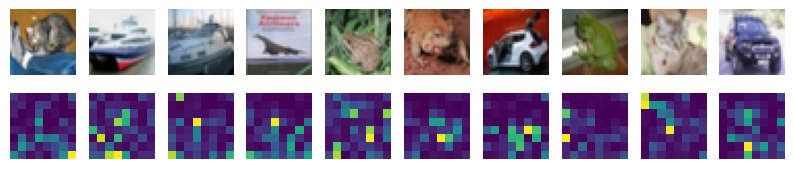

In [61]:
for val_batch in val_dataloader:
    break

model.eval()
with torch.no_grad():
    img, labels = val_batch
    img = img.cuda()
    outputs, attns = model(img, return_attn=True)

fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    flattened_attns = (
        attns.flatten(1, 2)[:, :, 0, 1:].mean(1).reshape(-1, 8, 8).cpu().numpy()
    )
    ax[0, i].imshow(inv_transform(img[i]))
    ax[1, i].imshow(flattened_attns[i])
    ax[0, i].axis(False)
    ax[1, i].axis(False)

# Problem 4: Dialogue GPT

In [ ]:
!pip install wget

In [ ]:
import wget
import os

if not os.path.exists("input.txt"):
    wget.download(
        "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    )

In [ ]:
with open("input.txt", "r") as f:
    raw_text = f.read()
all_dialogues = raw_text.split("\n\n")

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")

## Part 4.A

In [ ]:
def tokenize(s):
    return word_tokenize(s)


class MyTokenizer:
    def __init__(self, raw_text: str):
        # raw_text     contains the text from which we will build our vocabulary

        self.start = "<START>"  # token that starts every example
        self.pad = "<PAD>"  # token used to pad examples to the same length
        self.unk = "<UNK>"  # token used if encountering a word not in our vocabulary

        vocab = np.unique(tokenize(raw_text))
        vocab = np.concatenate([np.array([self.start, self.pad, self.unk]), vocab])

        self.vocab = vocab  # array of tokens in order
        self.tok_to_id = {w: i for i, w in enumerate(vocab)}  # mapping of token to ID
        self.vocab_size = len(self.vocab)  # size of vocabulary

    def encode(self, s: str) -> torch.Tensor:
        # s           input string
        #
        # Output
        # id_tensor   a tensor of token ids, starting with the start token.t

        id_tensor = None

        # TODO: tokenize the input using word_tokenize. Return a tensor
        # of the token ids, starting with the token id for the start token.
        # ============ ANSWER START ===========

        # ============ ANSWER END =============

        return id_tensor

    def decode(self, toks: torch.Tensor) -> str:
        # toks         a list of token ids
        #
        # Output
        # decoded_str  the token ids decoded back into a string (join with a space)

        decoded_str = None

        # TODO: convert the token ids back to the actual corresponding words.
        # Join the tokens with a space and return the full string
        # ============ ANSWER START ===========

        # ============ ANSWER END =============

        return decoded_str

    def pad_examples(self, tok_list: List[torch.Tensor]) -> torch.Tensor:
        # Pads the tensors to the right with the pad token so that they are the same length.
        #
        # tok_list       a list of tensors containing token ids (maybe of different lengths)
        #
        # Output
        # padded_tokens  shape: (len(tok_list), max length within tok_list)
        return torch.nn.utils.rnn.pad_sequence(
            tok_list, batch_first=True, padding_value=self.tok_to_id[self.pad]
        )


tok = MyTokenizer(raw_text)

In [ ]:
# tokenizer test cases
input_string = "KING RICHARD III:\nSay that I did all this for love of her."
enc = tok.encode(input_string)
print(enc)
dec = tok.decode(enc)
print(dec)
assert dec == "<START> KING RICHARD III : Say that I did all this for love of her ."

# Part 4.B

In [ ]:
class DialogueDataset:
    def __init__(self, tokenizer: MyTokenizer, lines: List[str], max_N: int):
        # tokenizer    an instance of MyTokenizer
        # lines        a list of strings. each element in an example in the dataset
        # max_N        the maximum number of tokens allowed per example. More than this will be truncated
        self.lines = lines
        self.tokenizer = tokenizer
        self.max_N = max_N

    def __len__(self) -> int:
        return len(self.lines)

    def __getitem__(self, idx: int) -> torch.Tensor:
        # returns the example at int encoded by the tokenizer
        # truncates the example if it is more than max_N tokens
        return self.tokenizer.encode(self.lines[idx])[: self.max_N]


def collate_fn(examples: List[torch.Tensor]):
    # examples        a batch of tensors containing token ids (maybe of different lengths)
    # Outputs a dictionary containing
    #   input_ids     a single tensor with all of the examples padded (from the right) to the max
    #                 length within the batch. shape:(B, max length within examples)
    #   input_mask    a tensor indicating which tokens are padding and should be ignored. 0 if padding
    #                 and 1 if not. shape: (B, max length within examples)
    new_input_ids = tok.pad_examples(examples)
    attn_mask = torch.ones(new_input_ids.shape)
    attn_mask[new_input_ids == tok.tok_to_id[tok.pad]] = 0
    return {"input_ids": tok.pad_examples(examples), "input_mask": attn_mask}


ds = DialogueDataset(tok, all_dialogues, max_N=200)
training_dl = torch.utils.data.DataLoader(ds, batch_size=64, collate_fn=collate_fn)

In [ ]:
# take a look at an example of an element from the training dataloader
for batch in training_dl:
    print(batch)
    break

## Part 4.C

In [ ]:
embs = torch.ones((32, 100, 128))
B, T, _ = embs.shape
pos_ids = torch.arange(T).expand(B, -1)
print(pos_ids)
pos_E = nn.Embedding(200, 128)
print(pos_E)
pos_E(pos_ids).shape

In [ ]:
class DialogueGPT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        max_N: int,
        dim: int,
        attn_dim: int,
        mlp_dim: int,
        num_heads: int,
        num_layers: int,
    ):
        # vocab_size       size of the vocabulary
        # max_N            maximum number of tokens allowed to appear in 1 example
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.

        super().__init__()

        # TODO: set up the token embedding and positional embeddings
        #       Hint, use nn.Embedding
        # ============ ANSWER START ============

        # ============ ANSWER END ==============

        self.transformer = Transformer(
            dim=dim,
            attn_dim=attn_dim,
            mlp_dim=mlp_dim,
            num_heads=num_heads,
            num_layers=num_layers,
        )

        self.head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, vocab_size))

    def forward(
        self, input_ids: torch.Tensor, return_attn=False
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # input_ids     a batch of input ids (right padded). shape: (B x T)
        # return_attn   whether to return the attention weights
        #
        # Output
        # out           the logit vector (B x T x V)
        # alphas        the attention weights if return_attn is True. Otherwise None shape: (B, num_layers, num_heads, T, T)

        embs = None

        # TODO: retrieve the token embeddings for the input_ids.
        #       Add to the token embeddings the positional embeddings.
        #       Store the combined embedding in embs
        # ============ ANSWER START ============

        # ============ ANSWER END ============

        causal_attn_mask = None

        # TODO: Create the causal attention mask, which should be of size (B, T, T)
        #       Remember that the causal attention mask is lower triangular (all tokens only
        #       depend on themselves and the tokens before them).
        # .      Store the mask in causal_attn_mask
        # Hint: check out torch.tril
        # ============ ANSWER START ============

        # ============ ANSWER END ==============

        x, alphas = self.transformer(
            embs, attn_mask=causal_attn_mask, return_attn=return_attn
        )
        out = self.head(x)
        return out, alphas

    def generate(self, input_ids, num_tokens):
        # you can assume batch size 1
        with torch.no_grad():
            for i in range(num_tokens):
                out, _ = self.forward(input_ids)
                new_token = torch.argmax(out[:, [-1]], -1)
                input_ids = torch.cat([input_ids, new_token], dim=1)
        return input_ids

## Part 4.D

In [ ]:
class DialogueLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(reduction="none")

    def forward(
        self, logits: torch.Tensor, input_ids: torch.Tensor, inp_mask: torch.Tensor
    ):
        # logits      the logits produced by DialogueGPT. shape: (B x T x V)
        # input_ids   the token ids. shape: (B x T)
        # inp_mask    a 0/1 mask of which tokens are padding tokens and should be ignored. shape: (B x T)

        # TODO: Implement the language model loss. For logits[i], we want to supervise the i+1 token_id
        # with the cross entropy loss. We thus will not supervise the start token (input_ids[0]) or use
        # the last logit vector (logits[-1]). Return the average of the losses for each token in the batch,
        # making sure to ignore tokens corresponding to the padding (use inp_mask).

        # ============ ANSWER START ============

        # ============ ANSWER END ==============
        return loss

## Part 4.F

In [ ]:
import torch.optim as optim

model = DialogueGPT(
    vocab_size=tok.vocab_size,
    max_N=200,
    dim=128,
    attn_dim=64,
    mlp_dim=128,
    num_heads=3,
    num_layers=6,
).cuda()
criterion = DialogueLoss()

NUM_EPOCHS = 80


optimizer = optim.AdamW(
    model.parameters(), lr=0.0001, weight_decay=0
)  # implement in homework
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [ ]:
# Time estimate: around 30 minutes on T4 GPU
# Training
import tqdm

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    loss_meter = AverageMeter()
    for inp_dict in tqdm.tqdm(training_dl):
        # get the inputs; data is a list of [inputs, labels]
        inp_ids, inp_mask = inp_dict["input_ids"], inp_dict["input_mask"]
        inp_ids = inp_ids.cuda()
        inp_mask = inp_mask.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = model(input_ids=inp_ids)
        loss = criterion(outputs, inp_ids, inp_mask)
        loss_meter.update(loss.item(), len(inp_dict["input_ids"]))
        loss.backward()
        optimizer.step()
    scheduler.step()

    # print example
    inp = tok.encode("").unsqueeze(0).cuda()
    print(tok.decode(model.generate(inp, 10)[0].cpu()))

    print(
        f"Train Epoch: {epoch}, Loss: {loss_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}"
    )

## Part 4.G

In [ ]:
inp = tok.encode("").unsqueeze(0).cuda()
print(tok.decode(model.generate(inp, 50)[0].cpu()))